# MFR 모델 작업 공장

## 실행 필수

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


### 훈련 데이터, 훈련 레이블

train_data => (900,100,300,3)

train_labels => (900,10) <= One Hot

다중 레이블을 표방

In [3]:
train_data = np.load(drive_path + "for_train_1129.npz")['arr_0']
train_labels = np.load(drive_path + 'for_train_labels_1129.npz')['arr_0']
print(f'train_data.shape : {train_data.shape}')
print(f'train_labels.shape: {train_labels.shape }')

train_data.shape : (900, 100, 300, 3)
train_labels.shape: (900, 10)


### predict data

훈련 데이터는 0 ~ 89 음악들

90번 음악들을 predict data로 전처리

### Modules

In [4]:
# (100, 300, 3)의 output
# scaling 없이 => sigmoid로
import librosa
import numpy as np
import librosa.display
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import RegularGridInterpolator #선형보간
import math
from scipy.ndimage import zoom


###################################### Modules

# base y, sr

def ext_base(path):
    y, sr = librosa.load(path)
    return y, sr

# Chroma_stft

def ext_chroma_stft(y, sr):
    chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
    # (12,1200)의 형태
    #print(f'original chroma_stft.shape : {chroma_stft.shape}')
    #print(f'slicing to [:,:1200]')
    chroma_stft = chroma_stft[:,:1200]
    """
    print(f'---------check----------')
    # 모두 양수인지 확인
    if np.all(chroma_stft >= 0):
        print(f'chroma_stft의 모든 원소가 양수')
    else:
        print(f'chroma_stft의 원소 중 음수가 존재')
    # 최대최소값 확인
    print(f'max : {np.max(chroma_stft)}')
    print(f'min : {np.min(chroma_stft)}')
    print(f'------------------------')
    """
    return chroma_stft

# MFCC

def ext_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y = y, sr = sr)
    #print(f'original mfcc.shape : {mfcc.shape}')
    #print(f'slicing to [:,:1200]')
    mfcc = mfcc[:,:1200]
    """
    print(f'scaling_minmax')
    scaler = MinMaxScaler()
    mfcc = scaler.fit_transform(mfcc.T).T
    print(f'---------check----------')
    if np.all(mfcc >= 0):
        print(f'mfcc의 모든 원소가 양수')
    else:
        print(f'mfcc의 원소 중 음수가 존재')
    print(f'max : {np.max(mfcc)}')
    print(f'min : {np.min(mfcc)}')
    print(f'------------------------')
    """

    return mfcc # 2차원

# Tempogram

def ext_tempogram(y, sr):
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    #print(f'slicing to [:,:1200]')
    tempogram = tempogram[:,:1200]
    """
    print(f'scaling_minmax')
    scaler = MinMaxScaler()
    tempogram = scaler.fit_transform(tempogram.T).T
    print(f'---------check----------')
    if np.all(tempogram >= 0):
        print(f'mfcc의 모든 원소가 양수')
    else:
        print(f'mfcc의 원소 중 음수가 존재')
    print(f'max : {np.max(tempogram)}')
    print(f'min : {np.min(tempogram)}')
    print(f'------------------------')
    """
    return tempogram # 2차원

# 선형 보간
"""
def interpolate_array_height(arr, new_height):
    # 주어진 배열의 크기
    original_height, original_width = arr.shape

    # 새로운 y 값 생성
    y_new = np.linspace(0, original_height - 1, new_height)

    # RegularGridInterpolator를 이용하여 보간된 함수 생성
    interp_func = RegularGridInterpolator((np.arange(original_height), np.arange(original_width)), arr)

    # 보간된 배열 생성
    x_new = np.arange(original_width)
    xx, yy = np.meshgrid(x_new, y_new)
    points = np.array([yy, xx]).transpose((1, 2, 0))
    arr_interpolated = interp_func(points)

    return arr_interpolated
"""

# zoom을 이용한 resizing
def return_zoomed(arr, new_height, new_width):
    zoomed = zoom(arr, (new_height/arr.shape[0], new_width/arr.shape[1]))
    return zoomed


############################################## integrate
# input => 파일 경로
# output => (100, 300, 3)의 데이터 포인트

def ext_datapoint(path):
    y ,sr = ext_base(path)

    feature_list= []

    chroma_stft = ext_chroma_stft(y, sr)
    feature_list.append(chroma_stft)
    mfcc = ext_mfcc(y, sr)
    feature_list.append(mfcc)
    tempogram = ext_tempogram(y, sr)
    feature_list.append(tempogram)

    # 선형 보간 => zoom 방식
    new_height, new_width = 100,300
    for idx, feature in enumerate(feature_list):
        feature_list[idx] = return_zoomed(feature, new_height, new_width)
        feature_list[idx] = np.expand_dims(feature_list[idx], axis = -1)

    #print(f'-------------linear interpolating done--------------')
    #print(f'-------------adding a dimension done--------------')
    #print(f'check!')
    for x in feature_list:
        print(x.shape, end = ' ')
    print()

    ### concatenate
    concatenated = np.concatenate(feature_list, axis = -1)
    #print(f'-------------concatenating done--------------')
    #print(f'check!')
    #print(f'concatenated.shape : {concatenated.shape}')

    return concatenated


from tensorflow.keras.models import load_model

########################################### (1,H,W,C) return
def ext_sample_input(file_path):
    sample_data = ext_datapoint(file_path)
    sample_data = np.expand_dims(sample_data, axis = 0)
    return sample_data

############################################ 10차원 결과 백터(list) return
def return_result(sample_input, model_path):
    loaded_model = load_model(model_path)
    prediction = loaded_model.predict(sample_input)
    return prediction[0]

### test data

In [5]:

target_music_num = 92
labeled_musics_path = drive_path + 'genres_original'
genres = os.listdir(labeled_musics_path)
genres.sort()
print(genres)
test_input_list = []
for genre in genres:
  now_folder_path = labeled_musics_path + '/' + genre
  musics = os.listdir(now_folder_path)
  musics.sort()
  target_path = now_folder_path + '/' + musics[target_music_num]
  temp = ext_sample_input(target_path)
  test_input_list.append(temp)
test_input_list = np.concatenate(test_input_list, axis = 0)


['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 
(100, 300, 1) (100, 300, 1) (100, 300, 1) 


### 시각화 모듈

In [6]:
def visualization(prediction):
    genres = os.listdir(labeled_musics_path)
    genres.sort()

    for idx, genre_preds in enumerate(prediction):
        max_index = np.argmax(genre_preds)
        second_index = np.argsort(genre_preds)[-2]  # 두 번째로 큰 값의 인덱스 찾기

        plt.subplot(2, 5, idx + 1)
        plt.bar(range(len(genre_preds)), genre_preds, color='b')

        plt.text(max_index, genre_preds[max_index], genres[max_index], ha='center', va='bottom')
        plt.text(second_index, genre_preds[second_index], genres[second_index], ha='center', va='bottom')  # 두 번째로 큰 값을 가진 막대에 장르 이름 표시

        plt.axis('off')
        plt.title(genres[idx])

    plt.show()


### ETA!

In [7]:
eta_input = ext_sample_input(drive_path + 'ETA.mp3')
eta_input_crnn = np.transpose(eta_input,(0,2,1,3))
print(f'eta_input.shape : {eta_input.shape}')
print(f'eta_input_crnn.shape : {eta_input_crnn.shape}')

def eta_visualization(prediction):
  genres = os.listdir(labeled_musics_path)
  genres.sort()

  for idx, genre_preds in enumerate(prediction):

      max_index = np.argmax(genre_preds)
      second_index = np.argsort(genre_preds)[-2]  # 두 번째로 큰 값의 인덱스 찾기

      plt.subplot(1, 1, idx + 1)
      plt.bar(range(len(genre_preds)), genre_preds, color='b')

      plt.text(max_index, genre_preds[max_index], genres[max_index], ha='center', va='bottom')
      plt.text(second_index, genre_preds[second_index], genres[second_index], ha='center', va='bottom')  # 두 번째로 큰 값을 가진 막대에 장르 이름 표시

      plt.axis('off')

  plt.show()



(100, 300, 1) (100, 300, 1) (100, 300, 1) 
eta_input.shape : (1, 100, 300, 3)
eta_input_crnn.shape : (1, 300, 100, 3)


# MFR_model_mk_3

Conv => 저 중 고 음역대를 한번씩 찍음.

맥스 풀링 X

바로 FCL

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (40, 10), activation='elu', input_shape=(100, 300, 3), strides = (30,10)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 3, 30, 32)         38432     
                                                                 
 flatten_27 (Flatten)        (None, 2880)              0         
                                                                 
 dense_54 (Dense)            (None, 64)                184384    
                                                                 
 dense_55 (Dense)            (None, 10)                650       
                                                                 
Total params: 223466 (872.91 KB)
Trainable params: 223466 (872.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(train_data, train_labels, epochs = 10, batch_size = 32)

Epoch 1/10
29/29 [==============================] - 2s 35ms/step - loss: 0.6035 - accuracy: 0.2333
Epoch 2/10
29/29 [==============================] - 2s 54ms/step - loss: 0.2575 - accuracy: 0.4689
Epoch 3/10
29/29 [==============================] - 2s 79ms/step - loss: 0.1779 - accuracy: 0.6567
Epoch 4/10
29/29 [==============================] - 4s 142ms/step - loss: 0.1415 - accuracy: 0.7478
Epoch 5/10
29/29 [==============================] - 3s 88ms/step - loss: 0.0972 - accuracy: 0.8478
Epoch 6/10
29/29 [==============================] - 3s 87ms/step - loss: 0.0713 - accuracy: 0.9278
Epoch 7/10
29/29 [==============================] - 1s 43ms/step - loss: 0.0445 - accuracy: 0.9622
Epoch 8/10
29/29 [==============================] - 1s 33ms/step - loss: 0.0269 - accuracy: 0.9856
Epoch 9/10
29/29 [==============================] - 1s 33ms/step - loss: 0.0165 - accuracy: 0.9978
Epoch 10/10
29/29 [==============================] - 1s 32ms/step - loss: 0.0103 - accuracy: 0.9967


1/1 [==============================] - 0s 76ms/step


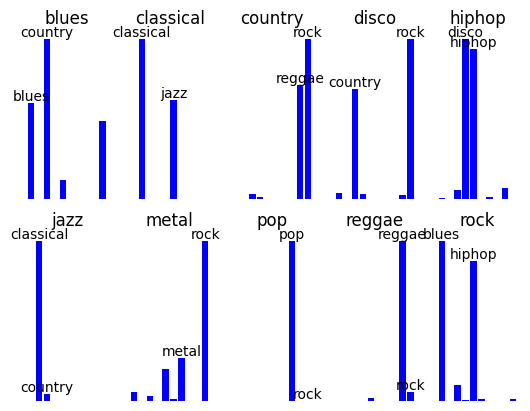

In [ ]:
result = model.predict(test_input_list)
visualization(result)

너무 강한 확신을 가짐. 정규화 과정이 필요

# MFR_model_mk_3_1

Dropout 0.2 추가

FCL을 절반으로

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (40, 10), activation='elu', input_shape=(100, 300, 3), strides = (30,10)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 30, 32)         38432     
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dropout (Dropout)           (None, 2880)              0         
                                                                 
 dense (Dense)               (None, 32)                92192     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 130954 (511.54 KB)
Trainable params: 13095

In [ ]:
model.fit(train_data, train_labels, epochs = 10, batch_size = 32)

Epoch 1/10
29/29 [==============================] - 2s 34ms/step - loss: 0.7807 - accuracy: 0.1578
Epoch 2/10
29/29 [==============================] - 1s 34ms/step - loss: 0.4755 - accuracy: 0.1856
Epoch 3/10
29/29 [==============================] - 1s 33ms/step - loss: 0.4036 - accuracy: 0.2567
Epoch 4/10
29/29 [==============================] - 1s 32ms/step - loss: 0.3412 - accuracy: 0.3133
Epoch 5/10
29/29 [==============================] - 1s 31ms/step - loss: 0.2986 - accuracy: 0.4122
Epoch 6/10
29/29 [==============================] - 1s 31ms/step - loss: 0.2897 - accuracy: 0.4267
Epoch 7/10
29/29 [==============================] - 1s 34ms/step - loss: 0.2684 - accuracy: 0.4733
Epoch 8/10
29/29 [==============================] - 2s 54ms/step - loss: 0.2575 - accuracy: 0.5133
Epoch 9/10
29/29 [==============================] - 2s 56ms/step - loss: 0.2547 - accuracy: 0.5200
Epoch 10/10
29/29 [==============================] - 2s 52ms/step - loss: 0.2263 - accuracy: 0.5711


1/1 [==============================] - 0s 98ms/step


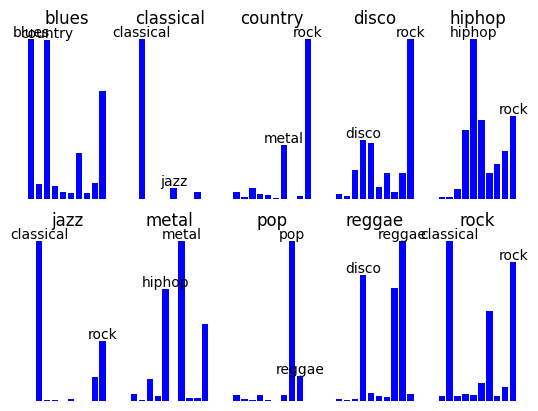

In [ ]:
result = model.predict(test_input_list)
visualization(result)

적삽성 양호, 모델 저장


In [ ]:
model.save(drive_path + 'MFR_model_mk_3_1_')

# MFR_model_mk_4

CRNN을 적용, (D,H,W,C) => (D,W,H,C) => W는 시간이므로

(D, W, H*C) => LSTM input

In [ ]:
# 훈련데이터
print(f'MFCC : {train_data[:,:,:,1].shape}')
mfccs = train_data[:,:,:,1]

"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape=(time_steps, features)),
    tf.keras.layers.Dense(10, activation='softmax')
])
#  (timesteps, features)로 바꿔줘야함
"""

mfccs = np.transpose(mfccs, (0,2,1))
print(f'MFCC : {mfccs.shape}')

###############################################################33

print(f'train_data : {train_data.shape}')
td_for_crnn = np.transpose(train_data, (0, 2, 1, 3))
print(f'td_for_crnn : {td_for_crnn.shape}')

MFCC : (900, 100, 300)
MFCC : (900, 300, 100)
train_data : (900, 100, 300, 3)
td_for_crnn : (900, 300, 100, 3)


#### crnn input으로 변경하는 모듈

원래 input (D, 100, 300, 3)을 (D, 300, 100, 3)으로

In [ ]:
def transpose_to_crnn_input(nparr):
  return np.transpose(nparr, (0,2,1,3))


In [ ]:
|
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(10,10), strides = (10,10), activation='elu', input_shape=(300, 100, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Reshape((30,10*32)),
    tf.keras.layers.LSTM(units=64, input_shape=(30, 10 * 32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 30, 10, 32)        9632      
                                                                 
 batch_normalization_14 (Ba  (None, 30, 10, 32)        128       
 tchNormalization)                                               
                                                                 
 reshape_4 (Reshape)         (None, 30, 320)           0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                98560     
                                                                 
 dense_77 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_15 (Ba  (None, 64)                256       
 tchNormalization)                                   

In [ ]:
model.fit(td_for_crnn, train_labels, epochs = 20, batch_size = 32)

Epoch 1/20
29/29 [==============================] - 6s 75ms/step - loss: 0.7154 - accuracy: 0.2644
Epoch 2/20
29/29 [==============================] - 2s 70ms/step - loss: 0.5944 - accuracy: 0.4611
Epoch 3/20
29/29 [==============================] - 4s 123ms/step - loss: 0.5206 - accuracy: 0.5689
Epoch 4/20
29/29 [==============================] - 4s 136ms/step - loss: 0.4433 - accuracy: 0.6256
Epoch 5/20
29/29 [==============================] - 4s 148ms/step - loss: 0.3708 - accuracy: 0.6322
Epoch 6/20
29/29 [==============================] - 4s 127ms/step - loss: 0.2961 - accuracy: 0.6756
Epoch 7/20
29/29 [==============================] - 2s 84ms/step - loss: 0.2380 - accuracy: 0.7156
Epoch 8/20
29/29 [==============================] - 3s 93ms/step - loss: 0.1954 - accuracy: 0.7778
Epoch 9/20
29/29 [==============================] - 3s 116ms/step - loss: 0.1771 - accuracy: 0.7800
Epoch 10/20
29/29 [==============================] - 3s 114ms/step - loss: 0.1475 - accuracy: 0.8156
Epo

1/1 [==============================] - 2s 2s/step


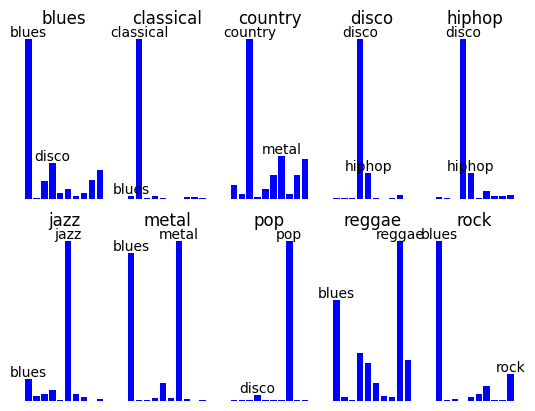

In [ ]:
test_crnn_list = np.transpose(test_input_list, (0,2,1,3))
prediction = model.predict(test_crnn_list)
visualization(prediction)

In [ ]:
model.save(drive_path + 'MFR_model_mk_4')

# MFR_model_mk_4_1

In [ ]:
td_for_crnn = np.load(drive_path + 'train_data_for_crnn.npz')['arr_0']
train_labels = np.load(drive_path + 'for_train_labels_1129.npz')['arr_0']

print(f'td_for_crnn : {td_for_crnn.shape}\n => CNN : (the_num_of_Datapoints, T, H, C)\n => LSTM (D, T, H*C)')
print(f'label_data : {train_labels.shape}')


train_data_for_crnn : (900, 300, 100, 3)
 => CNN : (the_num_of_Datapoints, T, H, C)
 => LSTM (D, T, H*C)
label_data : (900, 10)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(20,5),
        strides = (10,5),
        activation='elu',
        input_shape=(300, 100, 3),
        padding = 'same',
        kernel_initializer='glorot_uniform'
      ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = (1,2)),
    tf.keras.layers.Reshape((30,5*64)),
    tf.keras.layers.LSTM(units=64, input_shape=(30, 10 * 32)),
    tf.keras.layers.Dense(64, activation='relu',kernel_initializer='glorot_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(10, activation='sigmoid')

])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 30, 20, 32)        9632      
                                                                 
 batch_normalization_84 (Ba  (None, 30, 20, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 30, 10, 32)        0         
 ng2D)                                                           
                                                                 
 reshape_33 (Reshape)        (None, 30, 320)           0         
                                                                 
 lstm_33 (LSTM)              (None, 64)                98560     
                                                                 
 dense_118 (Dense)           (None, 64)              

In [ ]:
model.fit(td_for_crnn, train_labels, epochs = 15, batch_size = 45)

Epoch 1/15
20/20 [==============================] - 8s 188ms/step - loss: 0.7378 - accuracy: 0.2200
Epoch 2/15
20/20 [==============================] - 2s 120ms/step - loss: 0.6409 - accuracy: 0.3733
Epoch 3/15
20/20 [==============================] - 2s 108ms/step - loss: 0.5946 - accuracy: 0.4367
Epoch 4/15
20/20 [==============================] - 2s 107ms/step - loss: 0.5445 - accuracy: 0.4878
Epoch 5/15
20/20 [==============================] - 2s 108ms/step - loss: 0.4973 - accuracy: 0.5178
Epoch 6/15
20/20 [==============================] - 2s 124ms/step - loss: 0.4393 - accuracy: 0.5222
Epoch 7/15
20/20 [==============================] - 4s 188ms/step - loss: 0.3790 - accuracy: 0.5911
Epoch 8/15
20/20 [==============================] - 3s 161ms/step - loss: 0.3209 - accuracy: 0.6189
Epoch 9/15
20/20 [==============================] - 2s 109ms/step - loss: 0.2778 - accuracy: 0.6344
Epoch 10/15
20/20 [==============================] - 2s 109ms/step - loss: 0.2474 - accuracy: 0.6722

1/1 [==============================] - 0s 45ms/step


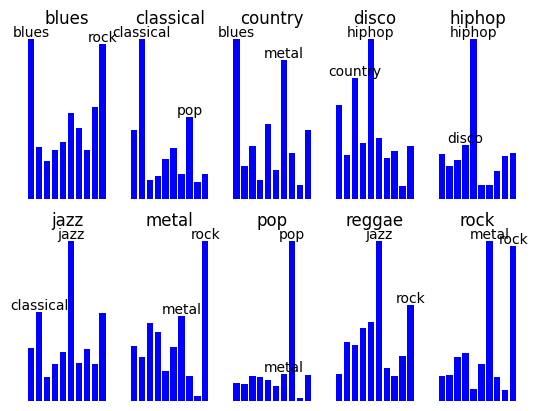

In [ ]:
test_crnn_list = np.transpose(test_input_list, (0,2,1,3))
prediction = model.predict(test_crnn_list)
visualization(prediction)

1/1 [==============================] - 0s 26ms/step


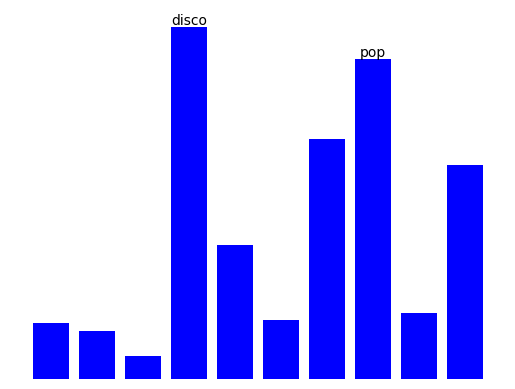

In [ ]:
eta_visualization(model.predict(eta_input_crnn))

In [ ]:
model.save(drive_path + 'MFR_model_mk_4_1')

# MFR_model_mk_5

In [ ]:
td_for_crnn = np.load(drive_path + 'train_data_for_crnn.npz')['arr_0']
train_labels = np.load(drive_path + 'for_train_labels_1129.npz')['arr_0']

print(f'td_for_crnn : {td_for_crnn.shape}\n => CNN : (the_num_of_Datapoints, T, H, C)\n => LSTM (D, T, H*C)')
print(f'label_data : {train_labels.shape}')

td_for_crnn : (900, 300, 100, 3)
 => CNN : (the_num_of_Datapoints, T, H, C)
 => LSTM (D, T, H*C)
label_data : (900, 10)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(20,5),
        strides = (10,5),
        activation='elu',
        input_shape=(300, 100, 3),
        padding = 'same',
        kernel_initializer='glorot_uniform'
      ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = (1,2)),
    tf.keras.layers.Reshape((30,5*64)),
    tf.keras.layers.LSTM(units=64, input_shape=(30, 10 * 32)),
    tf.keras.layers.Dense(128, activation='elu',kernel_initializer='glorot_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='swish',kernel_initializer='glorot_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu',kernel_initializer='glorot_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(10, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 20, 32)        9632      
                                                                 
 batch_normalization_47 (Ba  (None, 30, 20, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 30, 10, 32)        0         
 ng2D)                                                           
                                                                 
 reshape_15 (Reshape)        (None, 30, 320)           0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                98560     
                                                                 
 dense_47 (Dense)            (None, 128)             

In [ ]:
model.fit(td_for_crnn, train_labels, epochs = 5, batch_size = 90)

Epoch 1/5
10/10 [==============================] - 2s 169ms/step - loss: 0.2232 - accuracy: 0.7522
Epoch 2/5
10/10 [==============================] - 1s 137ms/step - loss: 0.2096 - accuracy: 0.7578
Epoch 3/5
10/10 [==============================] - 1s 139ms/step - loss: 0.1976 - accuracy: 0.7867
Epoch 4/5
10/10 [==============================] - 1s 138ms/step - loss: 0.1904 - accuracy: 0.8089
Epoch 5/5
10/10 [==============================] - 2s 204ms/step - loss: 0.1767 - accuracy: 0.8167


1/1 [==============================] - 0s 424ms/step


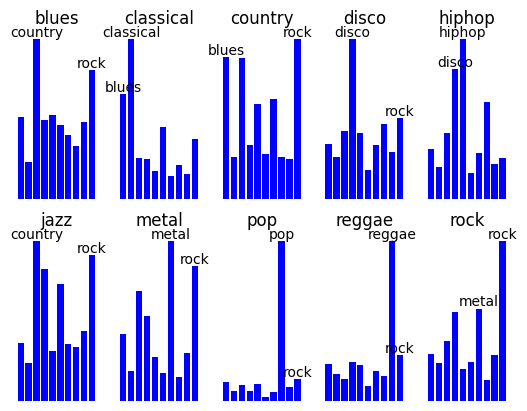

In [ ]:
test_crnn_list = np.transpose(test_input_list, (0,2,1,3))
prediction = model.predict(test_crnn_list)
visualization(prediction)


1/1 [==============================] - 0s 19ms/step


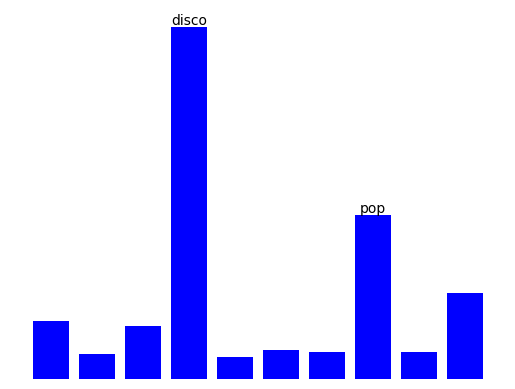

In [ ]:
eta_visualization(model.predict(eta_input_crnn))

In [ ]:
model.save(drive_path + 'MFR_model_mk_5')